# Kernel Latent Variable Time-varying Graphical Lasso
More than 1-Markovian!

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graph_lasso_; reload(time_graph_lasso_);
from regain.covariance import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
import time

from regainpr.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)

from regainpr.covariance import kernel_time_graphical_lasso_;
reload(kernel_time_graphical_lasso_);
from regainpr.covariance import kernel_latent_time_graphical_lasso_;
reload(kernel_latent_time_graphical_lasso_);

from regainpr import datasets; reload(datasets);
from regainpr import utils; reload(utils);

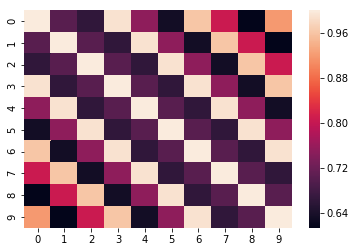

In [2]:
import seaborn as sns
# kernel used to generate data
sns.heatmap(kernels.ExpSineSquared(periodicity=np.pi,
                                      length_scale=2)(np.arange(10)[:,None]))

In [90]:
# setting 1
n_samples = 100
T = 10
n_dim_obs = 5

k = (n_dim_obs, T)

np.random.seed(0)

reload(datasets)
data = {(dim, T) : datasets.make_dataset(
    mode='sin', shape='smooth',
    update_theta='l2', normalize_starting_matrices=False,
    n_samples=n_samples, n_dim_lat=0, n_dim_obs=dim,  T=T, epsilon=1e-1,
    proportional=True, degree=2, keep_sparsity=True)
    for dim in [n_dim_obs]}

In [3]:
# setting 2 - sample from GPs
    n_samples = 100
    T = 10
    n_dim = 50

np.random.seed(2)   

reload(datasets)
data = [datasets.make_dataset(
    mode='gp', n_samples=n_samples, n_dim_lat=10, n_dim_obs=n_dim,  T=T, epsilon=0.4)
    for i in range(10)]

0.992%
0.996%
0.9984%
0.9896%
0.9912%
0.9832%
0.9976%
0.996%
0.9952%
0.9904%


In [4]:
# info on the data set
K = data[0].thetas
print ("Percentual of non-zero components at each time: {}".format(
    [(i!=0).sum() / i.size for i in K]))

print ("Percentual of total non-zero components: {}".format(
    (K != 0).sum() / (n_dim_obs ** 2 * T)))

Percentual of non-zero components at each time: [0.688, 0.6912, 0.6856, 0.6792, 0.692, 0.6864, 0.6744, 0.684, 0.6832, 0.66]


NameError: name 'n_dim_obs' is not defined

In [40]:
# prepare dataframe for results
n_dims = range(10)
n_times = [T]
methods = ['TGL', 'KTGL-exp', 'KTGL-rbf', 'LTGL', 'KLTGL-exp', 'KLTGL-rbf', 'WP']
scores = sorted([
    "MSE_precision", "MSE_observed", "MSE_latent", 'estimator', "mean_rank_error",
    'time', 'iterations', 'precision', 'recall', 'accuracy', 'balanced_accuracy',
    'f1', 'npv', 'prevalence', 'miss_rate', 'likelihood',
    'specificity', 'plr', 'nlr'])

cols = pd.MultiIndex.from_product([scores, n_dims], names=('score', 'dim'))
rows = pd.MultiIndex.from_product([methods, n_times], names=('method', 'time'))

df = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

In [41]:
%run kltgl_performance.py

In [42]:
# beta = 0.5
# rng = np.full(T-1, 1000)
# kernel_phi = np.diag(rng,1) +np.diag(rng,-1) + np.eye(T)
# kernel_phi = np.full((T ,T), 1000)

from kltgl_performance import *

In [43]:
# run_results(data[:2], dff, scores)

idx = pd.IndexSlice
for i, res in enumerate(data):
    if i > 5 or i < 2: continue
    # dim = k[0]
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    # to use it later for grid search
    data_grid = np.array(data_list).transpose(1, 2, 0)
    T = data_list.shape[0]
    print("Start with: dim=%d, T=%d (it %d)" % (data_list.shape[-1], T, i))

    # print("starting TGL ...\r", end='')
    # res = tgl_results(
    #     data_grid,
    #     K,
    #     K_obs,
    #     ells,
    #     search_spaces={'alpha': (1e-4, 1e+1, 'log-uniform')},
    # )
    # df.loc[idx['TGL', T], idx[:, i]] = [res.get(x, None) for x in scores]

    # print("starting KTGL - exp...\r", end='')
    # res = ktgl_results(
    #     data_list, K, K_obs, ells, search_spaces={
    #         'alpha': (1e-4, 1e+1, 'log-uniform'),
    #         'ker_param': (1e-4, 1e+1, 'log-uniform')
    #     })
    # df.loc[idx['KTGL-exp', T], idx[:, i]] = [
    #     res.get(x, None) for x in scores
    # ]

    # print("starting KTGL - rbf ...\r", end='')
    # res = ktgl_results(
    #     data_list, K, K_obs, ells, search_spaces={
    #         'alpha': (1e-4, 1e+1, 'log-uniform'),
    #         'ker_param': (1e-4, 1e+1, 'log-uniform')
    #     }, kernel=partial(kernels.RBF))
    # df.loc[idx['KTGL-rbf', T], idx[:, i]] = [
    #     res.get(x, None) for x in scores
    # ]

    print("starting LTGL ...\r", end='')
    res = ltgl_results(
        data_grid, K, K_obs, ells, search_spaces={
            'alpha': (1e-4, 1e+1, 'log-uniform'),
            'tau': (1e-4, 1e+1, 'log-uniform'),
            'beta': (1e-4, 1e+1, 'log-uniform'),
        }, eta=20)
    df.loc[idx['LTGL', T], idx[:, i]] = [res.get(x, None) for x in scores]
    alpha = res['estimator'].alpha
    tau = res['estimator'].tau

    print("starting KLTGL - exp ...\r", end='')
    res = kltgl_results(
        data_list, K, K_obs, ells, search_spaces={
            # 'alpha': (1e-4, 1e+1, 'log-uniform'),
            # 'tau': (1e-4, 1e+1, 'log-uniform'),
            'ker_psi_param': (1e-4, 1e+1, 'log-uniform'),
        }, alpha=alpha, tau=tau,
        ker_phi_param=20, kernel_phi=partial(kernels.ConstantKernel))
    df.loc[idx['KLTGL-exp', T], idx[:, i]] = [
        res.get(x, None) for x in scores
    ]

    print("starting KLTGL - rbf ...\r", end='')
    res = kltgl_results(
        data_list,
        K,
        K_obs,
        ells,
        search_spaces={
            # 'alpha': (1e-4, 1e+1, 'log-uniform'),
            # 'tau': (1e-4, 1e+1, 'log-uniform'),
            'ker_psi_param': (1e-4, 1e+1, 'log-uniform'),
        },
        alpha=alpha,
        tau=tau,
        ker_phi_param=20,
        kernel_phi=partial(kernels.ConstantKernel),
        kernel_psi=partial(kernels.RBF),
    )
    df.loc[idx['KLTGL-rbf', T], idx[:, i]] = [
        res.get(x, None) for x in scores
    ]

    # print("starting WP ...\r", end='')
    # res = wp_results(data_list, K)
    # df.loc[idx['WP', T], idx[:, i]] = [res.get(x, None) for x in scores]

Start with: dim=50, T=10 (it 0)
Start with: dim=50, T=10 (it 1)


/home/fede/src/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fede/src/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


/home/fede/src/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fede/src/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fede/src/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fede/src/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fede/src/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fede/src/scikit-optimize/skopt/optimizer/optimizer.py:399: UserWarnin

In [48]:
dff_mean_std = pd.DataFrame()
for s in scores:
    dff_mean_std["%s_mean" % s] = df[s].mean(axis=1)
    dff_mean_std["%s_std" % s] = df [s].std(axis=1)

In [49]:
dff_mean_std

,,MSE_latent_mean,MSE_latent_std,MSE_observed_mean,MSE_observed_std,MSE_precision_mean,MSE_precision_std,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,...,precision_mean,precision_std,prevalence_mean,prevalence_std,recall_mean,recall_std,specificity_mean,specificity_std,time_mean,time_std
method,time,,,,,,,,,,,,,,,,,,,,,
TGL,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTGL-exp,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTGL-rbf,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTGL,10,0.290358,0.410087,1.395601,0.305344,0.981695,0.010537,0.47476,0.002093,0.519265,0.009719,...,0.713975,0.000712,0.6922,0.013859,0.402074,0.029460,0.636456,0.048899,71183.133502,2434.347727
KLTGL-exp,10,0.278791,0.393728,1.250558,0.233138,0.956190,0.031506,0.47000,0.012332,0.516360,0.009011,...,0.711594,0.000283,0.6922,0.013859,0.393436,0.055376,0.639283,0.073399,91611.322241,40275.991738
KLTGL-rbf,10,0.298646,0.421807,1.343588,0.236910,0.975997,0.029617,0.46584,0.009843,0.515696,0.009557,...,0.711289,0.000366,0.6922,0.013859,0.383835,0.050420,0.647557,0.069534,89714.287573,39543.810241
WP,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# mm = dff.xs(n_dim_obs, level='dim', axis=1).xs(T, level='time')
mm = dff_mean_std.xs(T, level='time')
# mm['likelihood']
mm

,MSE_latent_mean,MSE_latent_std,MSE_observed_mean,MSE_observed_std,MSE_precision_mean,MSE_precision_std,accuracy_mean,accuracy_std,balanced_accuracy_mean,balanced_accuracy_std,...,precision_mean,precision_std,prevalence_mean,prevalence_std,recall_mean,recall_std,specificity_mean,specificity_std,time_mean,time_std
method,,,,,,,,,,,,,,,,,,,,,
TGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTGL-exp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTGL-rbf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LTGL,0.290358,0.410087,1.395601,0.305344,0.981695,0.010537,0.47476,0.002093,0.519265,0.009719,...,0.713975,0.000712,0.6922,0.013859,0.402074,0.029460,0.636456,0.048899,71183.133502,2434.347727
KLTGL-exp,0.278791,0.393728,1.250558,0.233138,0.956190,0.031506,0.47000,0.012332,0.516360,0.009011,...,0.711594,0.000283,0.6922,0.013859,0.393436,0.055376,0.639283,0.073399,91611.322241,40275.991738
KLTGL-rbf,0.298646,0.421807,1.343588,0.236910,0.975997,0.029617,0.46584,0.009843,0.515696,0.009557,...,0.711289,0.000366,0.6922,0.013859,0.383835,0.050420,0.647557,0.069534,89714.287573,39543.810241
WP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
tmp = mm[["f1_mean", "accuracy_mean", "mean_rank_error_mean", "MSE_precision_mean", "time_mean"]]

In [52]:
import os
from decimal import Decimal
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    print(s.name, any([s.name.startswith(i) for i in ["f1","accuracy"]]))
    
    m = s.max() if any([s.name.startswith(i) for i in ["f1","accuracy"]]) else s.min()
    is_max = s == m

    s_ = s.copy()
    s_[is_max] = '\textbf{%s}' % ('%.3f' % Decimal(m) if isinstance(m, float) else m)
    return s_

path = "/home/fede/Dropbox (DIBRIS)/projects/graphical models in time/kernel LTGL/exps"
tmp.apply(highlight_max).fillna("-").to_latex(
    os.path.join(path, "results_mean_10latent_50dim_21jan.tex"),
    float_format=lambda x: '%.3f' % x, escape=False)

f1_mean True
f1_mean True
accuracy_mean True
mean_rank_error_mean False
MSE_precision_mean False
time_mean False


In [151]:
tmp

,f1_mean,accuracy_mean,mean_rank_error_mean,MSE_precision_mean,time_mean
method,,,,,
TGL,0.840677,0.7340,NaN,0.246265,185.066961
KTGL-exp,0.842785,0.7338,NaN,0.145503,846.195786
KTGL-rbf,0.837572,0.7272,NaN,0.226018,824.218011
LTGL,0.772805,0.6788,3.97,0.569576,392.617439
KLTGL-exp,0.822098,0.7064,4.13,0.322114,1867.071245
KLTGL-rbf,0.800986,0.6874,5.47,0.501341,1957.718554
WP,NaN,NaN,NaN,NaN,NaN


In [30]:
mdl = kernel_time_graph_lasso_.KernelTimeGraphLasso(
    time_on_axis='last', assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
    max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]), update_rho_options=dict(mu=5))
mdl.fit(data_grid)
mdl.score(data_grid)

-6648.427421079336

In [31]:
X = np.vstack(data_list)
y = np.array([np.ones(x.shape[0]) *i for i, x in enumerate(data_list)]).flatten().astype(int)

In [37]:
reload(prox)
reload(time_graph_lasso_)
reload(kernel_time_graph_lasso_);

from functools import partial

from sklearn.model_selection import StratifiedKFold

from skopt.optimizer import optimizer; reload(optimizer)
from skopt import searchcv; reload(searchcv)
from skopt.space import Categorical
# include below until https://github.com/scikit-optimize/scikit-optimize/issues/718 is resolved
class BayesSearchCV(searchcv.BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

mdl = kernel_time_graph_lasso_.NewKernelTimeGraphLasso(
    alpha=0.5, psi='laplacian',
    assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
    max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]), update_rho_options=dict(mu=5),
    kernel=partial(kernels.ExpSineSquared, periodicity=np.pi), length_scale=2)

bscv = BayesSearchCV(mdl, search_spaces={
        'alpha': (1e-4, 1e+1, 'log-uniform'),  
        'length_scale': (1e-4, 1e+1, 'log-uniform'),
#         'kernel': Categorical([partial(kernels.ExpSineSquared, periodicity=np.pi),
#                                kernels.RBF]),  # categorical parameter
    },
    n_iter=50, n_points=3, cv=StratifiedKFold(3))

bscv.fit(X, y)
bscv.score(X, y)

-6664.273982392405

In [38]:
bscv.best_params_

{'alpha': 0.5792194050871016, 'length_scale': 0.38781388320536275}

In [ ]:
reload(wishart_process_)
wp = wishart_process_.WishartProcess(time_on_axis='first', verbose=True).fit(data_list)

wp.likelihood(wp.D_map)

wp.loglikes_after_burnin.max()

wp.store_precision = True

wp.score(data_list)

In [ ]:
mm = dff.xs(n_dim_obs, level='dim', axis=1).xs(T, level='time')
mm

In [ ]:
np.abs(dff.estimator[100]['TGL'][10].precision_ - dff.estimator[100]['KTGL'][10].precision_)

In [ ]:
from decimal import Decimal
' & '.join(['%.3f' % Decimal(i) for i in mm['MSE_precision']])

In [ ]:
dff[[s for s in scores if s != 'estimator']].to_pickle("dff_setting_1.pkl")

In [ ]:
l1 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LTGL ($\ell_2^2$)'].latent_])
l2 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LTGL ($\ell_1$)'].latent_])
l3 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LVGLASSO'].L])

l4 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LTGL ($\ell_2^2$)'].latent_])
l5 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LTGL ($\ell_1$)'].latent_])
l6 = ([np.linalg.matrix_rank(r) for r in mm.estimator['LVGLASSO'].L])

In [ ]:
l1,l2,l3,l4,l5,l6 = utils.load_pickle(filename="ells.pkl")

In [ ]:
import collections
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2,1, sharey=False, figsize=(10,5), dpi=600)

colors = ['white', 'lightblue', 'C7']
alpha = 0.95

counter=collections.Counter(l1)
ax1.bar(counter.keys(), np.array(counter.values())/len(l1), 
        alpha=alpha, width=0.24, label='LTGL ($\ell_2^2$)', color=colors[0], edgecolor='k')
counter=collections.Counter(l2)
ax1.bar(np.array(counter.keys())+0.25, np.array(counter.values())/len(l1), 
        alpha=alpha, width=0.24, label='LTGL ($\ell_1$)', color=colors[1], edgecolor='k')
counter=collections.Counter(l3)
ax1.bar(np.array(counter.keys())-0.25, np.array(counter.values())/len(l1), 
        alpha=alpha, width=0.24, label='LVGLASSO', color=colors[2], edgecolor='k')

ax1.set_xticks(range(0,30, 2))
#ax1.set_ylim(0,5)
ax1.axvline(20, c='r', ls='--')
ax1.set_xlabel(r'ranks of L obtained with ($p_2$)')
ax1.set_ylabel('frequency')
# ax1.set_xscale("log")
# ax1.set_xlim([10, 100])
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

#ax1.legend()
# ax0.legend(prop={'size': 10})
# ax0.set_title('bars with legend')


counter=collections.Counter(l4)
ax2.bar(counter.keys(), np.array(counter.values())/len(l4), 
        alpha=alpha, width=0.24, label='LTGL ($\ell_2^2$)', color=colors[0], edgecolor='k')
counter=collections.Counter(l5)
ax2.bar(np.array(counter.keys())+0.25,  
        np.array(counter.values())/len(l4), alpha=alpha, width=0.24, label='LTGL ($\ell_1$)', color=colors[1],
        edgecolor='k')
counter=collections.Counter(l6)
ax2.bar(np.array(counter.keys())-0.25,  
        np.array(counter.values())/len(l4), alpha=alpha, width=0.24, label='LVGLASSO', color=colors[2],
       edgecolor='k')

ax2.set_xticks(range(0,30,2))
# ax2.set_xlim(2.5,6.7)
ax2.set_xlabel(r'ranks of L obtained with ($p_1$)')
ax2.set_ylabel('frequency')
ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)
ax2.axvline(5, c='r', ls='--')
ax1.legend(loc='upper left', fontsize='x-large')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib
f.savefig("ranks_distribution_vertical.pdf", dpi=600, transparent=True, bbox_inches='tight')

In [ ]:
import collections
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,2.6), dpi=600)

colors = ['white', 'lightblue', 'C7']
alpha = 0.5

counter=collections.Counter(l1)
ax1.plot(range(len(l1)), l1, 
        alpha=alpha, label='LTGL ($\ell_2^2$)', color=colors[0])
counter=collections.Counter(l2)
ax1.plot(np.arange(len(l1))+.2, l2, 
        alpha=alpha,  label='LTGL ($\ell_1$)', color=colors[1])
counter=collections.Counter(l3)
ax1.plot(np.arange(len(l1))+.4, l3,
        alpha=alpha, label='LVGLASSO', color=colors[2])

# ax1.set_xticks(range(15,25, 1))
#ax1.set_ylim(0,5)
ax1.axhline(20, c='r', ls='--')
ax1.set_xlabel(r'ranks of L obtained with ($p_2$)')
ax1.set_ylabel('frequency')
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

#ax1.legend()
# ax0.legend(prop={'size': 10})
# ax0.set_title('bars with legend')


counter=collections.Counter(l4)
ax2.plot(range(len(l4)), l4, 
        alpha=alpha,label='LTGL ($\ell_2^2$)', color=colors[0])
counter=collections.Counter(l5)
ax2.plot(np.arange(len(l4))+.2, l5,
        alpha=alpha,  label='LTGL ($\ell_1$)', color=colors[1])
counter=collections.Counter(l6)
ax2.plot(np.arange(len(l4))+.4, l6, alpha=alpha,label='LVGLASSO', color=colors[2])

# ax2.set_xticks(range(10))
# ax2.set_xlim(2.5,6.7)
ax2.set_xlabel(r'ranks of L obtained with ($p_1$)')
ax2.xaxis.label.set_size(15)
ax2.axhline(5, c='r', ls='--')
ax1.legend(loc='best', fontsize='large')
plt.tight_layout()
plt.show()